## Import Library
* 자주 사용하는 기본적인 Library 읽기

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
#import tensorflow as tf

import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using plaidml.keras.backend backend.


## Load Data

In [2]:
%time data = pd.read_csv("./Processed_data_final_ver2.csv")
X_data = data.drop(["label","label2"],axis=1)
y_data = data["label2"]

CPU times: user 145 ms, sys: 26 ms, total: 171 ms
Wall time: 170 ms


## Under Sampling

In [3]:
import imblearn
X_data, y_data = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority', random_state=1004).fit_resample(X_data, y_data)

## Mapping

In [4]:
y_data[y_data == "four"] = 1
y_data[y_data == "good"] = 2
y_data[y_data == "gun"] = 3
y_data[y_data == "okay"] = 4
y_data[y_data == "one"] = 5
y_data[y_data == "paper"] = 6
y_data[y_data == "rock"] = 7
y_data[y_data == "rest"] = 0
y_data[y_data == "scissor"] = 8
y_data[y_data == "three"] = 9

## Train - Test Split & Scaling

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, stratify=y_data, random_state=1004)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

## Grid Search

### ANN

* Define Model

In [6]:
def my_model(hidden_layer_num, node_size, batch_normalization, drop_out, drop_out_rate, learning_rate):
    model = keras.Sequential()
    
    ### Input Layer
    model.add(keras.layers.InputLayer(input_shape=(18,)))
    
    ### Hidden Layer
    for i in range(hidden_layer_num):
        model.add(keras.layers.Dense(node_size))
        if batch_normalization: model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())
        if drop_out: model.add(keras.layers.Dropout(drop_out_rate))    
    
    ### Output Layer
    model.add(keras.layers.Dense(10))
    model.add(keras.layers.Softmax())
    
    ### Compile
    model.compile(optimizer= keras.optimizers.Adam(learning_rate), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=["accuracy"])
    
    return model

* Scikit Learn - Keras API 적용

In [7]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=my_model)

* Grid_search setting

In [10]:
from sklearn.model_selection import GridSearchCV

parameter = {'hidden_layer_num' : [2, 3, 4], 
             "node_size": [300, 600, 1000], 
             'drop_out': [False, True], 
             'batch_normalization' : [False, True], 
             'drop_out_rate': [0.1, 0.2, 0.3, 0.4], 
             'learning_rate': [0.001, 0.0001], 
             'epochs':[500, 1000, 2000], 
             'batch_size':[2**10]}
grid_search = GridSearchCV(estimator= model, param_grid=parameter, n_jobs=1, cv=10)

* Model 학습

In [11]:
from tqdm.keras import TqdmCallback
%time grid_search.fit(X_train_scaled, y_train)

Epoch 1/500
17910/17910 [==============================] - 0s 24us/step - loss: 1.9510 - acc: 0.3280
Epoch 2/500
17910/17910 [==============================] - 0s 20us/step - loss: 1.6532 - acc: 0.3978
Epoch 3/500
17910/17910 [==============================] - 0s 20us/step - loss: 1.5670 - acc: 0.4226
Epoch 4/500
17910/17910 [==============================] - 0s 22us/step - loss: 1.5359 - acc: 0.4320
Epoch 5/500
17910/17910 [==============================] - 0s 22us/step - loss: 1.4974 - acc: 0.4442
Epoch 6/500
17910/17910 [==============================] - 0s 22us/step - loss: 1.4805 - acc: 0.4490
Epoch 7/500
17910/17910 [==============================] - 0s 20us/step - loss: 1.4524 - acc: 0.4545
Epoch 8/500
17910/17910 [==============================] - 0s 20us/step - loss: 1.4363 - acc: 0.4644
Epoch 9/500
17910/17910 [==============================] - 0s 20us/step - loss: 1.4143 - acc: 0.4695
Epoch 10/500
17910/17910 [==============================] - 0s 20us/step - loss: 1.4048 - a

GridSearchCV(cv=2, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1a1c067f50>,
             iid='deprecated', n_jobs=1,
             param_grid={'batch_normalization': [True], 'batch_size': [1024],
                         'drop_out': [True], 'drop_out_rate': [0.3],
                         'epochs': [500], 'hidden_layer_num': [3],
                         'learning_rate': [0.001], 'node_size': [600]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

* ANN Test Score

In [12]:
ann_test_score = grid_search.score(X_test_scaled, y_test)
print("ANN Test Score : {0}".format(ann_test_score))

3980/3980 [==============================] - 0s 86us/step
ANN Test Score : 0.8982411913536302


* ANN Confussion Matrix

/Users/kyunghyunlee/anaconda3/envs/emg/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/kyunghyunlee/anaconda3/envs/emg/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


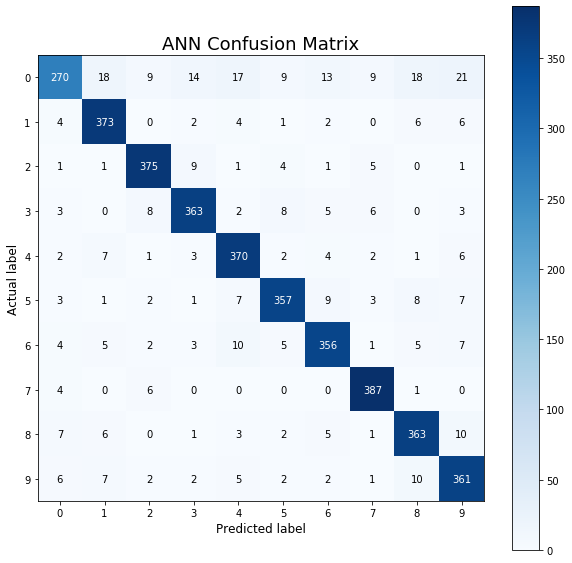

In [15]:
import mglearn
# 오차행렬
plt.rcParams['figure.figsize'] = (10, 10) #figure size
plt.rcParams.update({'axes.labelsize': 'large'}) #axes label size

scores_image = mglearn.tools.heatmap(
    confusion_matrix(np.array(y_test).astype('int'), grid_search.predict(X_test_scaled).astype('int')), 
    xlabel='Predicted label', 
    ylabel='Actual label', xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], yticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], cmap='Blues', fmt="%d")

plt.title("ANN Confusion Matrix", fontsize=18)
plt.gca().invert_yaxis()
plt.colorbar(scores_image)
plt.show()

In [16]:
result = grid_search.cv_results_
df_result = pd.DataFrame(result)
df_result.to_csv("./Result/ann_grid_result.csv", encoding="CP949", index=False)